# 2.3_自动求梯度

## 2.3.1 概念

上一节介绍的`Tensor`是这个包的核心类，如果将其属性`.requires_grad`设置为`True`，它将开始追踪(track)在其上的所有操作。完成计算后，可以调用`.backward()`来完成所有梯度计算。此`Tensor`的梯度将累积到`.grad`属性中。

> 注意在调用`.backward()`时，如果`Tensor`是标量，则不需要为`backward()`指定任何参数；否则，需要指定一个求导变量。

如果不想要被继续追踪，可以调用`.detach()`将其从追踪记录中分离出来，这样就可以防止将来的计算被追踪。此外，还可以用`with torch.no_grad()`将不想被追踪的操作代码块包裹起来，这种方法在评估模型的时候很常用，因为在评估模型时，我们并不需要计算可训练参数（`requires_grad=True`）的梯度。

`Function`是另外一个很重要的类。`Tensor`和`Function`互相结合就可以构建一个记录有整个计算过程的非循环图。每个`Tensor`都有一个`.grad_fn`属性，该属性即创建该`Tensor`的`Function`（除非用户创建的`Tensor`s时设置了`grad_fn=None`）。

下面通过一些例子来理解这些概念。

## 2.3.2 `Tensor`

In [31]:
import torch

print(torch.__version__)

1.1.0


创建一个Tensor并设置requires_grad=True:

In [3]:
x = torch.ones(2, 2, requires_grad = True)
print(x)
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [4]:
y = x + 2
print(y)
print(y.grad_fn)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


<br/>
注意x是直接创建的，所以它没有grad_fn, 而y是通过一个加法操作创建的，所以它有一个为<AddBackward>的grad_fn。

<br/>
<br/>

像x这种直接创建的称为叶子节点，叶子节点对应的grad_fn是None。
<br/>

In [5]:
print(x.is_leaf, y.is_leaf) # True False

True False


In [15]:
aa = torch.ones(2,2) + 1
bb = torch.ones(2,2) + 1
print(aa)
print(bb)
print(aa.mm(bb))
print(torch.dot(torch.tensor([2, 3]), torch.tensor([2, 1]))) #即对应位置相乘再相加

tensor([[2., 2.],
        [2., 2.]])
tensor([[2., 2.],
        [2., 2.]])
tensor([[8., 8.],
        [8., 8.]])
tensor(7)


In [6]:
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


通过.requires_grad_()来用in-place的方式改变requires_grad属性：

In [23]:
a = torch.randn(2, 2) # 缺失情况下默认 requires_grad = False
a = ((a * 3) / (a - 1))
print(a.requires_grad) # False
a.requires_grad_(True)
print(a.requires_grad) # True
b = (a * a).sum()
print(a)
print(b)
print(b.grad_fn)

False
True
tensor([[ 0.4092, -0.8321],
        [ 1.8671,  1.4795]], requires_grad=True)
tensor(6.5350, grad_fn=<SumBackward0>)


## 2.3.3 梯度

因为out是一个标量，所以调用backward()时不需要指定求导变量：

In [29]:
out.backward() # 等价于 out.backward(torch.tensor(1.))

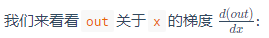

In [30]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


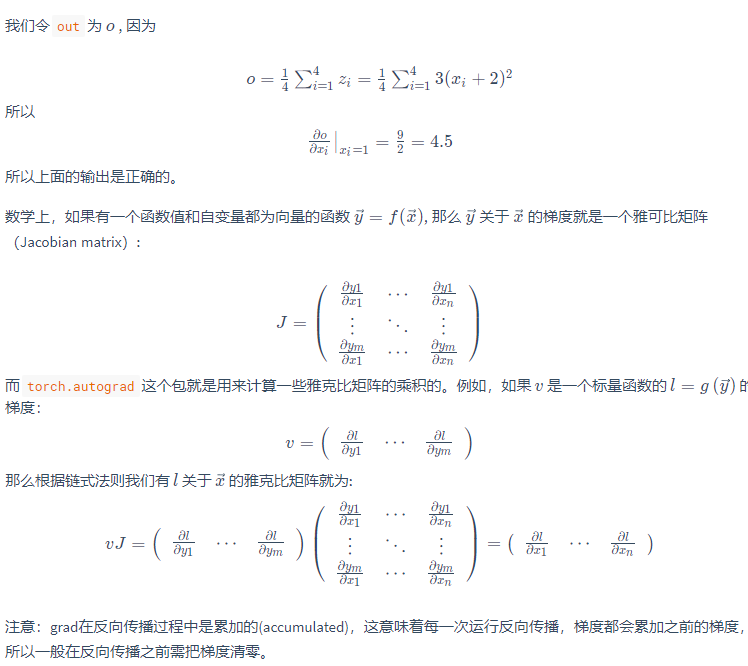

参考链接 ： [如何理解雅可比式？](https://www.zhihu.com/question/57763170)

In [32]:
# 再来反向传播一次，注意grad是累加的
out2 = x.sum()
out2.backward()
print(x.grad)

out3 = x.sum()
x.grad.data.zero_()
out3.backward()
print(x.grad)

tensor([[5.5000, 5.5000],
        [5.5000, 5.5000]])
tensor([[1., 1.],
        [1., 1.]])


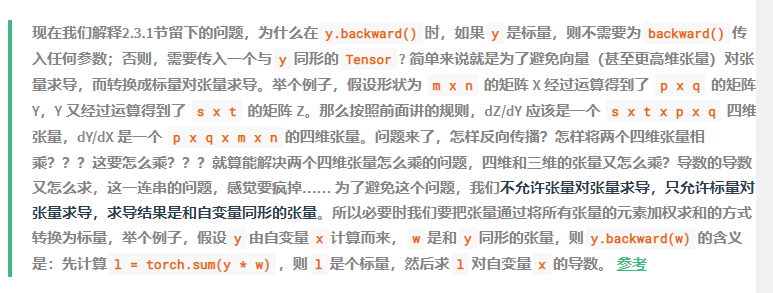

来看一些实际例子。

In [43]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)
y = 4 * x
z = y.view(2, 2) # .view 共享内存
print(x.grad)
print(z)

None
tensor([[ 4.,  8.],
        [12., 16.]], grad_fn=<ViewBackward>)


In [44]:
v = torch.tensor([[1.0, 0.1], [0.01, 0.001]], dtype=torch.float)
z.backward(v)
print(x.grad)

tensor([4.0000, 0.4000, 0.0400, 0.0040])


注意，x.grad是和x同形的张量。

再来看看中断梯度追踪的例子：

In [45]:
x = torch.tensor(1.0, requires_grad=True)
y1 = x ** 2 
with torch.no_grad():
    y2 = x ** 3
y3 = y1 + y2

print(x.requires_grad)
print(y1, y1.requires_grad) # True
print(y2, y2.requires_grad) # False
print(y3, y3.requires_grad) # True

True
tensor(1., grad_fn=<PowBackward0>) True
tensor(1.) False
tensor(2., grad_fn=<AddBackward0>) True


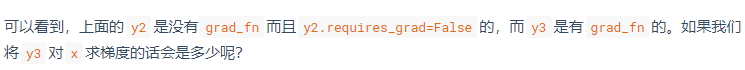

In [46]:
y3.backward()
print(x.grad)

tensor(2.)


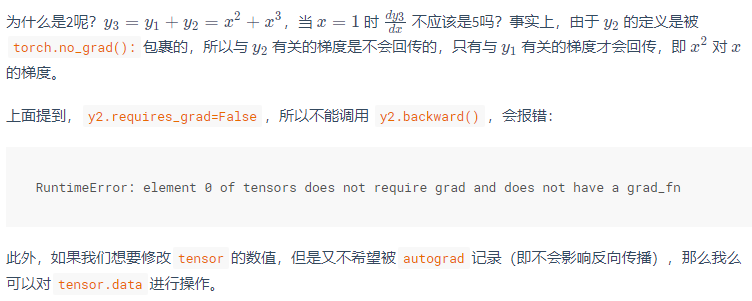

In [48]:
x = torch.ones(1,requires_grad=True)

print(x.data) # 还是一个tensor
print(x.data.requires_grad) # 但是已经是独立于计算图之外

y = 2 * x
x.data *= 100 # 只改变了值，不会记录在计算图，所以不会影响梯度传播

y.backward()
print(x) # 更改data的值也会影响tensor的值
print(x.grad)

tensor([1.])
False
tensor([100.], requires_grad=True)
tensor([2.])
